In [1]:
import os
import glob
import torch
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Project imports
from traffic_rl.config import AppConfig
from traffic_rl.env.traffic_env import TrafficLightEnv
from traffic_rl.agents.dqn import DQNAgent
from traffic_rl.agents.q_learning import QLearningAgent # <--- Added this
from traffic_rl.tools.visualizer import generate_gif

%matplotlib inline

# Load Config
config = AppConfig.load("configs/default.yaml")
print("✅ Config loaded.")

C:\Users\vlasi\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Config loaded.


In [2]:
def load_agent(agent_folder, config):
    """
    Detects if the folder is DQN or Q-Learning and loads the right file.
    """
    # Determine Agent Type from Folder Name
    folder_name = os.path.basename(agent_folder)
    
    # Initialize Environment (needed for dimensions)
    env = TrafficLightEnv(config.env)
    
    agent = None
    model_path = None
    
    # DQN 
    if "dqn" in folder_name.lower():
        print(f"🔹 Detected DQN Agent in: {folder_name}")
        agent = DQNAgent(
            state_dim=env.observation_space.shape[0], 
            action_dim=env.action_space.n, 
            config=config.agent, 
            device="cpu"
        )
        # Look for .pt files
        if os.path.exists(os.path.join(agent_folder, "best_model.pt")):
            model_path = os.path.join(agent_folder, "best_model.pt")
        elif os.path.exists(os.path.join(agent_folder, "model.pt")):
            model_path = os.path.join(agent_folder, "model.pt")

    #  Q-LEARNING
    elif "q_learning" in folder_name.lower():
        print(f"🔸 Detected Q-Learning Agent in: {folder_name}")
        agent = QLearningAgent(
            action_dim=env.action_space.n,
            config=config.agent
        )
        # Look for .pkl files
        if os.path.exists(os.path.join(agent_folder, "model.pkl")):
            model_path = os.path.join(agent_folder, "model.pkl")
            
    # LOAD WEIGHTS
    if agent and model_path:
        print(f"   📂 Loading weights from: {os.path.basename(model_path)}")
        try:
            agent.load(model_path)
            return env, agent
        except Exception as e:
            print(f"   ❌ Error loading: {e}")
            return None, None
    else:
        print("   ❌ No model file found (.pt or .pkl).")
        return None, None

print("Universal Loader defined.")

Universal Loader defined.


In [3]:
import os
import glob

root_dir = "experiments" 

# We filter with os.path.isdir to ensure we only get folders
experiment_groups = sorted([d for d in glob.glob(os.path.join(root_dir, "*")) if os.path.isdir(d)])

if not experiment_groups:
    print(f"❌ No experiment folders found in '{root_dir}'. Check spelling.")
else:
    print(f"📂 Found {len(experiment_groups)} Groups in '{root_dir}':")
    for i, group in enumerate(experiment_groups):
        print(f"   [{i}] {os.path.basename(group)}")

    # Choose Group 
    group_index = 0  # <--- CHANGE THIS (0 = Baseline, 1 = Optimized)
    
    if group_index < len(experiment_groups):
        selected_group = experiment_groups[group_index]
        print(f"\n👉 Selected Group: {os.path.basename(selected_group)}")
        
        #  Find Specific Models inside the group (e.g., "Best_Baseline", "Best_Baseline_Q")
        model_folders = sorted([d for d in glob.glob(os.path.join(selected_group, "*")) if os.path.isdir(d)])
        
        if not model_folders:
            print(f"   ❌ No models found inside {os.path.basename(selected_group)}")
        else:
            print("\n   🤖 Models found inside:")
            for j, mf in enumerate(model_folders):
                print(f"      [{j}] {os.path.basename(mf)}")
                
            # Choose Specific Model -
            model_index = 0 # <--- CHANGE THIS (0 = Standard, 1 = Q-Table version, etc.)
            
            if model_index < len(model_folders):
                target_agent_folder = model_folders[model_index]
                print(f"\n✅ Final Target: {target_agent_folder}")
                
                 #Load 
                 #env, agent = load_agent(target_agent_folder, config)
            else:
                print(f"❌ Model index {model_index} is out of range.")
    else:
        print(f"❌ Group index {group_index} is out of range.")

📂 Found 2 Groups in 'experiments':
   [0] Baseline
   [1] Optimized

👉 Selected Group: Baseline

   🤖 Models found inside:
      [0] Best_Baseline-dqn
      [1] Best_Baseline_q_learning

✅ Final Target: experiments\Baseline\Best_Baseline-dqn


🎥 Generating GIF...


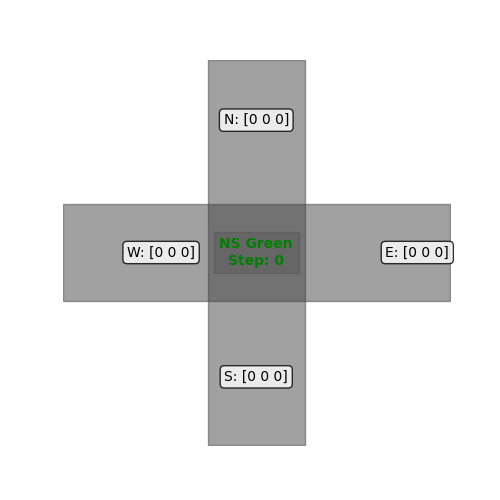

In [6]:
if agent:
    gif_name = "./notebook_deep_dive.gif"
    print(f"🎥 Generating GIF...")
    generate_gif(env, agent, output_path=gif_name)
    display(Image(filename=gif_name))

📈 Found metrics at: Best_Baseline-dqn/metrics.csv


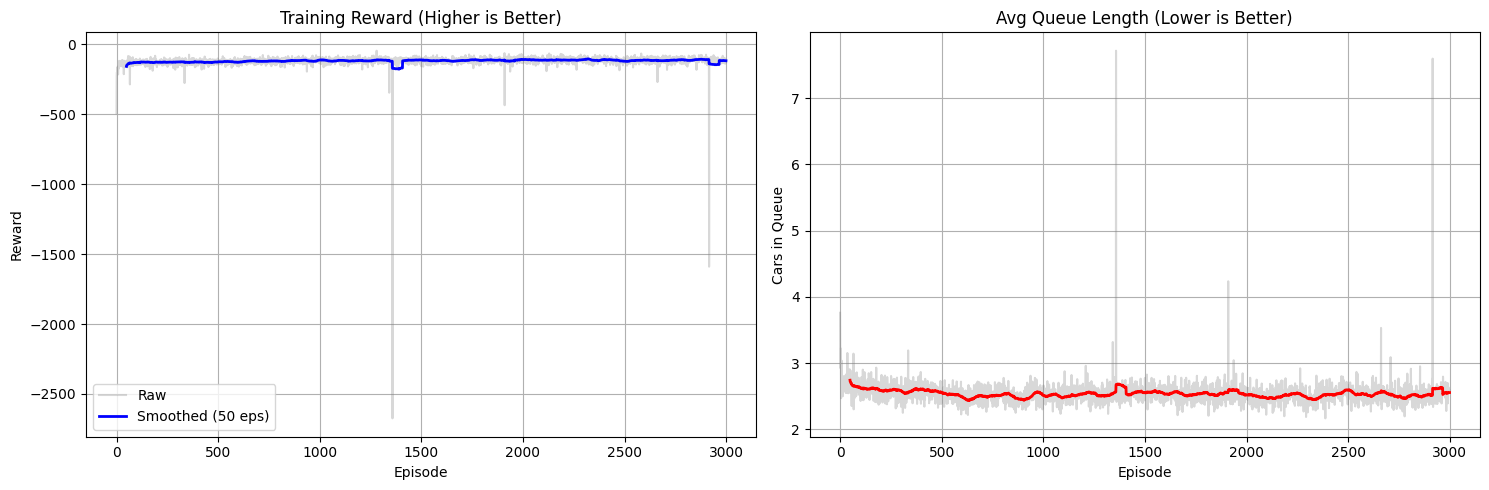

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Locate the CSV file for the selected agent
csv_path = os.path.join(target_agent_folder, "metrics.csv")

if os.path.exists(csv_path):
    print(f"📈 Found metrics at: {os.path.basename(target_agent_folder)}/metrics.csv")
    
    # Read Data
    df = pd.read_csv(csv_path)
    
    # Create Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot A: Reward (The Learning Curve)
    # We use a "Rolling Mean" (window=50) to smooth out the noise and show the trend
    ax1.plot(df['episode'], df['reward'], alpha=0.3, color='gray', label='Raw')
    ax1.plot(df['episode'], df['reward'].rolling(window=50).mean(), color='blue', linewidth=2, label='Smoothed (50 eps)')
    ax1.set_title("Training Reward (Higher is Better)")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")
    ax1.legend()
    ax1.grid(True)
    
    # Plot B: Average Queue Length (The Traffic Performance)
    if 'avg_queue' in df.columns:
        ax2.plot(df['episode'], df['avg_queue'], alpha=0.3, color='gray')
        ax2.plot(df['episode'], df['avg_queue'].rolling(window=50).mean(), color='red', linewidth=2)
        ax2.set_title("Avg Queue Length (Lower is Better)")
        ax2.set_xlabel("Episode")
        ax2.set_ylabel("Cars in Queue")
        ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("❌ No metrics.csv found. Did this agent finish training?")

🚀 Processing: experiments\Baseline\Best_Baseline-dqn
🔹 Detected DQN Agent in: Best_Baseline-dqn
   📂 Loading weights from: model.pt
⚠️  Converting legacy model architecture for model.pt

🚦 Starting Stress Test on DQNAgent (Seed 42)...
   Testing: Low (1.0x)... Done. (2.31s)
   Testing: Normal (1.5x)... Done. (1.95s)
   Testing: High (4.0x)... Done. (23.95s)
   Testing: Saturated (6.0x)... Done. (60.38s)


C:\Users\vlasi\AppData\Local\Temp\ipykernel_85396\3699878305.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_stress, x="Scenario", y="Avg Wait Time (s)", palette="viridis")


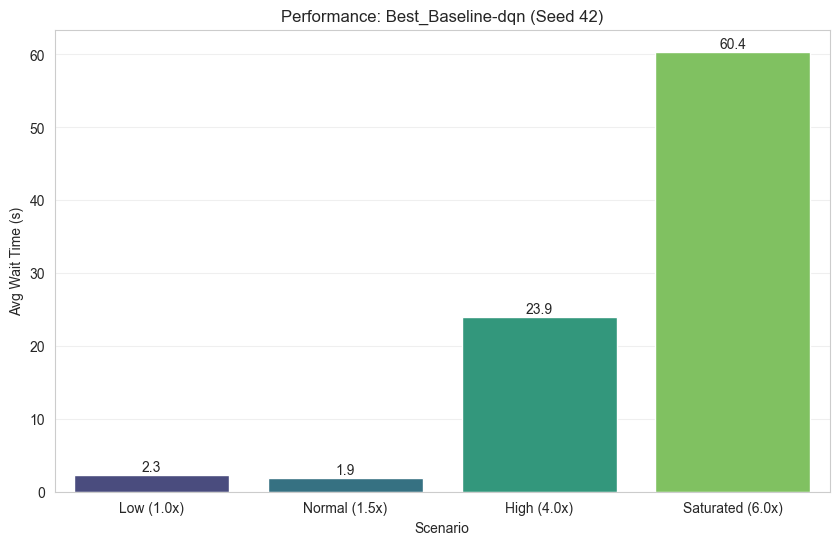

,Scenario,Avg Wait Time (s)
0,Low (1.0x),2.314131
1,Normal (1.5x),1.945769
2,High (4.0x),23.947363
3,Saturated (6.0x),60.379562


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
from traffic_rl.config import EnvConfig, AppConfig
from traffic_rl.env.traffic_env import TrafficLightEnv 
from traffic_rl.agents.dqn import DQNAgent
from traffic_rl.agents.q_learning import QLearningAgent

# REDEFINE LOAD_AGENT (Fixing the .pt vs .pkl issue)
def load_agent(agent_folder, config):
    """
    Robust loader that handles both DQN and Q-Learning, 
    and checks for both .pt and .pkl extensions.
    """
    if not os.path.exists(agent_folder): return None, None
    folder_name = os.path.basename(agent_folder)
    env = TrafficLightEnv(config.env)
    agent = None
    model_path = None
    
    # DQN Detection 
    if "dqn" in folder_name.lower():
        print(f"🔹 Detected DQN Agent in: {folder_name}")
        agent = DQNAgent(
            state_dim=env.observation_space.shape[0], 
            action_dim=env.action_space.n, 
            config=config.agent, 
            device="cpu"
        )
        if os.path.exists(os.path.join(agent_folder, "best_model.pt")):
            model_path = os.path.join(agent_folder, "best_model.pt")
        elif os.path.exists(os.path.join(agent_folder, "model.pt")):
            model_path = os.path.join(agent_folder, "model.pt")

    # Q-LEARNING Detection 
    elif "q_learning" in folder_name.lower():
        print(f"🔸 Detected Q-Learning Agent in: {folder_name}")
        agent = QLearningAgent(
            action_dim=env.action_space.n,
            config=config.agent
        )
        if os.path.exists(os.path.join(agent_folder, "model.pkl")):
            model_path = os.path.join(agent_folder, "model.pkl")
        elif os.path.exists(os.path.join(agent_folder, "model.pt")):
            model_path = os.path.join(agent_folder, "model.pt")
            
    # Load Weights 
    if agent and model_path:
        print(f"   📂 Loading weights from: {os.path.basename(model_path)}")
        try:
            agent.load(model_path)
            return env, agent
        except Exception as e:
            print(f"   ❌ Error loading file: {e}")
            return None, None
    else:
        print(f"   ❌ No model file found in {agent_folder}")
        return None, None

# SCENARIOS (Updated to include Saturated)
SCENARIOS = {
    "Low (1.0x)": 1.0, 
    "Normal (1.5x)": 1.5,
    "High (4.0x)": 4.0, 
    "Saturated (6.0x)": 6.0
}

# UPDATED: Enforce Seed 42 and 1 Episode
def evaluate_stress_test(base_env_config, agent, episodes=1):
    print(f"\n🚦 Starting Stress Test on {agent.__class__.__name__} (Seed 42)...")
    results = []
    
    for name, mult in SCENARIOS.items():
        print(f"   Testing: {name}...", end=" ")
        
        test_conf = EnvConfig(
            arrival_rates=base_env_config.arrival_rates,
            traffic_multiplier=mult,
            max_steps=1000
        )
        test_env = TrafficLightEnv(test_conf)
        
        avg_waits = []
        for _ in range(episodes):
            # FIXED: Seed 42
            state, _ = test_env.reset(seed=42)
            done = False
            total_q = 0
            total_flow = 0
            
            while not done:
                action = agent.act(state, training=False)
                state, _, done, truncated, info = test_env.step(action)
                done = done or truncated
                total_q += info['total_queue']
                total_flow += info['throughput']
            
            wait_time = (total_q / total_flow) if total_flow > 0 else total_q
            avg_waits.append(wait_time)
            
        mean_wait = np.mean(avg_waits)
        results.append({"Scenario": name, "Avg Wait Time (s)": mean_wait})
        print(f"Done. ({mean_wait:.2f}s)")
        
    return pd.DataFrame(results)

# Config Loader
try:
    config = AppConfig.load("configs/default.yaml")
except:
    class Dummy: pass
    config = Dummy(); config.env = Dummy(); config.env.arrival_rates = {"N_to_S": 0.1}; config.env.traffic_multiplier = 1.0
    config.agent = Dummy(); config.agent.name="dqn"; config.agent.hidden_dim=128; config.agent.double_dqn=False; config.agent.dueling_dqn=False
    config.agent.epsilon_start=1.0; config.agent.epsilon_min=0.01; config.agent.epsilon_decay=0.99; config.agent.alpha=0.1; config.agent.gamma=0.99

if 'target_agent_folder' not in locals():
    print("❌ Error: 'target_agent_folder' variable is missing. Run the selection cell first.")
else:
    print(f"🚀 Processing: {target_agent_folder}")
    env, agent = load_agent(target_agent_folder, config)

    if agent:
        # Run Stress Test
        df_stress = evaluate_stress_test(config.env, agent)
        
        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_stress, x="Scenario", y="Avg Wait Time (s)", palette="viridis")
        plt.title(f"Performance: {os.path.basename(target_agent_folder)} (Seed 42)")
        plt.ylabel("Avg Wait Time (s)")
        plt.grid(axis='y', alpha=0.3)
        for index, row in df_stress.iterrows():
            plt.text(index, row["Avg Wait Time (s)"] + 0.5, f'{row["Avg Wait Time (s)"]:.1f}', ha="center")
        plt.show()
        display(df_stress)

🔹 Initializing Baselines...
🔹 Loading DQN from: experiments/Optimized/Best_Optimized-dqn
🔹 Detected DQN Agent in: Best_Optimized-dqn
   📂 Loading weights from: model.pt
⚠️  Converting legacy model architecture for model.pt
🔹 Loading Q-Learning from: experiments/Optimized/Best_Optimized_q_learning
🔸 Detected Q-Learning Agent in: Best_Optimized_q_learning
   📂 Loading weights from: model.pt

🚦 Starting Comparison of 4 Agents (Seed 42)...
   🏃 Running Fixed Time... Done.
   🏃 Running Adaptive... Done.
   🏃 Running DQN... Done.
   🏃 Running Q-Learning... Done.


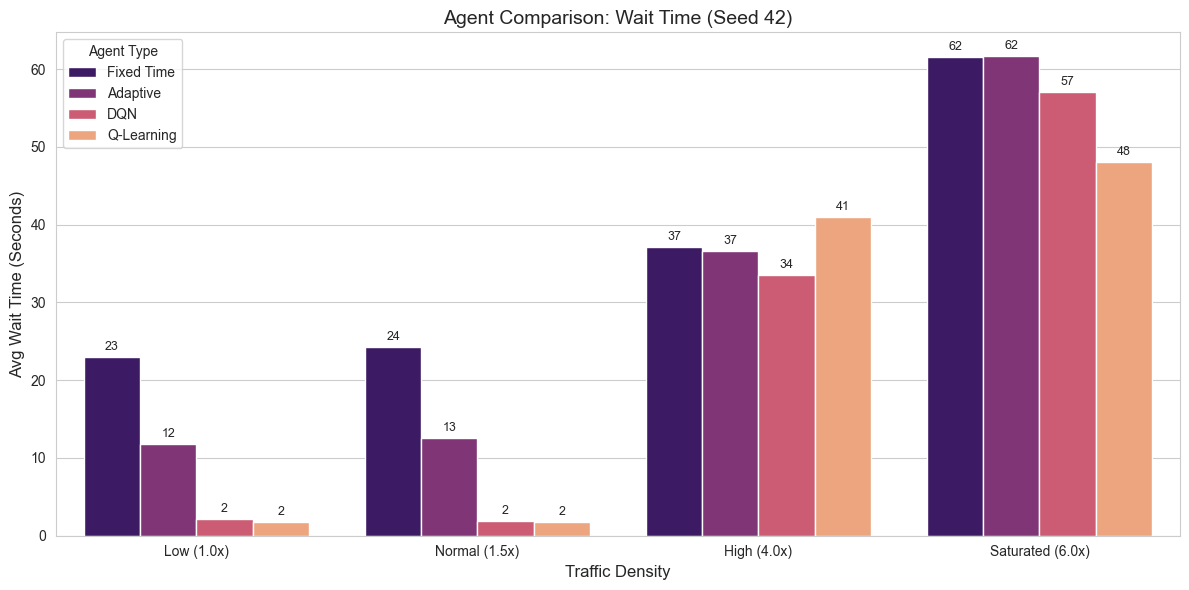

Agent,Fixed Time,Adaptive,Q-Learning,DQN
Scenario,,,,
High (4.0x),37.082527,36.602909,41.029667,33.508747
Low (1.0x),23.008226,11.767526,1.757658,2.104054
Normal (1.5x),24.299517,12.579185,1.757440,1.892431
Saturated (6.0x),61.553795,61.664497,48.042973,57.028679


In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from traffic_rl.config import AppConfig, EnvConfig
from traffic_rl.env.traffic_env import TrafficLightEnv
from traffic_rl.agents.baselines import FixedTimeAgent, AdaptiveAgent

# This needs to be updated manually.
DQN_FOLDER = "experiments/Optimized/Best_Optimized-dqn"         
Q_LEARNING_FOLDER = "experiments/Optimized/Best_Optimized_q_learning" 

# SETUP & LOAD CONFIG
try:
    config = AppConfig.load("configs/default.yaml")
except:
    print("⚠️ Config not found. Using defaults.")

# PREPARE AGENT DICTIONARY
agents_to_compare = {}

# Add Baselines 
print("🔹 Initializing Baselines...")
agents_to_compare["Fixed Time"] = FixedTimeAgent() 
agents_to_compare["Adaptive"] = AdaptiveAgent() 

# Load Trained Agents
if 'load_agent' in locals():
    print(f"🔹 Loading DQN from: {DQN_FOLDER}")
    _, dqn_agent = load_agent(DQN_FOLDER, config)
    if dqn_agent: 
        agents_to_compare["DQN"] = dqn_agent
    else:
        print(f"   ⚠️ Could not load DQN. Check path: {DQN_FOLDER}")

    print(f"🔹 Loading Q-Learning from: {Q_LEARNING_FOLDER}")
    _, q_agent = load_agent(Q_LEARNING_FOLDER, config)
    if q_agent: 
        agents_to_compare["Q-Learning"] = q_agent
    else:
        print(f"   ⚠️ Could not load Q-Learning. Check path: {Q_LEARNING_FOLDER}")
else:
    print("❌ Error: 'load_agent' function not found. Please run the previous code cell first.")

# RUN COMPARISON LOOP
SCENARIOS = {
    "Low (1.0x)": 1.0, 
    "Normal (1.5x)": 1.5,
    "High (4.0x)": 4.0, 
    "Saturated (6.0x)": 6.0
}

comparison_results = []

print(f"\n🚦 Starting Comparison of {len(agents_to_compare)} Agents (Seed 42)...")

for agent_name, agent in agents_to_compare.items():
    print(f"   🏃 Running {agent_name}...", end=" ")
    
    for scen_name, mult in SCENARIOS.items():
        # Temp Config
        test_conf = EnvConfig(
            arrival_rates=config.env.arrival_rates,
            traffic_multiplier=mult,
            max_steps=1000
        )
        env = TrafficLightEnv(test_conf)
        
        # UPDATED: Single Episode, Seed 42
        avg_waits = []
        for _ in range(1): # Reduced to 1 run
            state, _ = env.reset(seed=42) # FIXED: Seed 42
            done = False
            total_q = 0
            total_flow = 0
            
            while not done:
                if hasattr(agent, 'epsilon'): # RL Agents
                    action = agent.act(state, training=False)
                else: # Baselines
                    action = agent.act(state) 
                
                state, _, done, truncated, info = env.step(action)
                done = done or truncated
                
                total_q += info['total_queue']
                total_flow += info['throughput']
            
            wait = (total_q / total_flow) if total_flow > 0 else total_q
            avg_waits.append(wait)
            
        mean_wait = np.mean(avg_waits)
        comparison_results.append({
            "Agent": agent_name,
            "Scenario": scen_name,
            "Wait Time (s)": mean_wait
        })
    print("Done.")

# VISUALIZATION
if comparison_results:
    df_comp = pd.DataFrame(comparison_results)
    
    # Create Grouped Bar Chart
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    chart = sns.barplot(
        data=df_comp, 
        x="Scenario", 
        y="Wait Time (s)", 
        hue="Agent", 
        palette="magma" 
    )
    
    plt.title("Agent Comparison: Wait Time (Seed 42)", fontsize=14)
    plt.ylabel("Avg Wait Time (Seconds)", fontsize=12)
    plt.xlabel("Traffic Density", fontsize=12)
    plt.legend(title="Agent Type")
    
    # Add number labels on bars
    for container in chart.containers:
        chart.bar_label(container, fmt='%.0f', padding=3, fontsize=9)
        
    plt.tight_layout()
    plt.show()
    
    # Display Data Table
    pivot_df = df_comp.pivot(index="Scenario", columns="Agent", values="Wait Time (s)")
    cols = [c for c in ["Fixed Time", "Adaptive", "Q-Learning", "DQN"] if c in pivot_df.columns]
    display(pivot_df[cols].style.background_gradient(cmap="RdYlGn_r", axis=1))
else:
    print("❌ No results to plot.")


🔄 Loading Agents...
⚠️  Converting legacy model architecture for model.pt
   ✅ DQN (Base)
⚠️  Converting legacy model architecture for model.pt
   ✅ DQN (Opt)
   ✅ Q-Learn (Base)
   ✅ Q-Learn (Opt)

🚦 Running Deterministic Test (Seed 42)...
   🏃 Fixed Time... Done
   🏃 Adaptive... Done
   🏃 DQN (Base)... Done
   🏃 DQN (Opt)... Done
   🏃 Q-Learn (Base)... Done
   🏃 Q-Learn (Opt)... Done


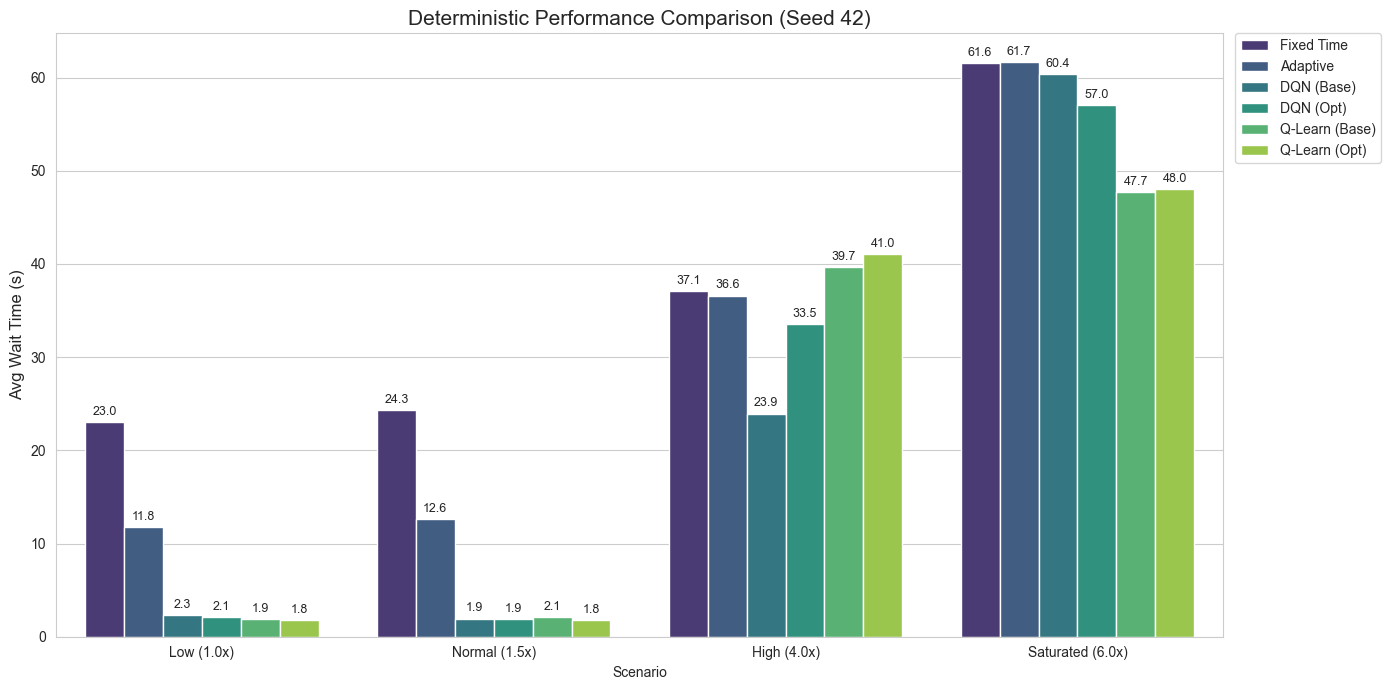


📊 Wait Times (Seconds)


Agent,Fixed Time,Adaptive,Q-Learn (Base),Q-Learn (Opt),DQN (Base),DQN (Opt)
Scenario,,,,,,
High (4.0x),37.08,36.60,39.66,41.03,23.95,33.51
Low (1.0x),23.01,11.77,1.89,1.76,2.31,2.10
Normal (1.5x),24.30,12.58,2.14,1.76,1.95,1.89
Saturated (6.0x),61.55,61.66,47.70,48.04,60.38,57.03


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from traffic_rl.config import AppConfig, EnvConfig
from traffic_rl.env.traffic_env import TrafficLightEnv
from traffic_rl.agents.baselines import FixedTimeAgent, AdaptiveAgent
from traffic_rl.agents.dqn import DQNAgent
from traffic_rl.agents.q_learning import QLearningAgent

# CONFIGURATION
PATH_DQN_BASE = "experiments/Baseline/Best_Baseline-dqn"
PATH_DQN_OPT  = "experiments/Optimized/Best_Optimized-dqn"
PATH_QL_BASE  = "experiments/Baseline/Best_Baseline_q_learning"
PATH_QL_OPT   = "experiments/Optimized/Best_Optimized_q_learning"

FIXED_SEEDS = [42] 

def load_agent_local(agent_folder, config):
    if not os.path.exists(agent_folder): return None
    folder_name = os.path.basename(agent_folder)
    env = TrafficLightEnv(config.env)
    
    if "dqn" in folder_name.lower():
        agent = DQNAgent(env.observation_space.shape[0], env.action_space.n, config.agent, device="cpu")
        p = os.path.join(agent_folder, "best_model.pt")
        if not os.path.exists(p): p = os.path.join(agent_folder, "model.pt")
        if os.path.exists(p): 
            try: agent.load(p); return agent
            except: return None
            
    elif "q_learning" in folder_name.lower():
        agent = QLearningAgent(env.action_space.n, config.agent)
        p = os.path.join(agent_folder, "model.pkl")
        if not os.path.exists(p): p = os.path.join(agent_folder, "model.pt")
        if os.path.exists(p): 
             try: agent.load(p); return agent
             except: return None
    return None

# SETUP & LOAD
try:
    config = AppConfig.load("configs/default.yaml")
except:
    print("⚠️ Config missing, using defaults.")
    class Dummy: pass
    config = Dummy(); config.env = Dummy(); config.env.arrival_rates = {"N_to_S": 0.1}; config.env.traffic_multiplier = 1.0
    config.agent = Dummy(); config.agent.name="dqn"; config.agent.hidden_dim=128; config.agent.double_dqn=False; config.agent.dueling_dqn=False
    config.agent.epsilon_start=1.0; config.agent.epsilon_min=0.01; config.agent.epsilon_decay=0.99; config.agent.alpha=0.1; config.agent.gamma=0.99

agents_dict = {}
agents_dict["Fixed Time"] = FixedTimeAgent()
agents_dict["Adaptive"]   = AdaptiveAgent()

print("🔄 Loading Agents...")
for lbl, p in [("DQN (Base)", PATH_DQN_BASE), ("DQN (Opt)", PATH_DQN_OPT), 
               ("Q-Learn (Base)", PATH_QL_BASE), ("Q-Learn (Opt)", PATH_QL_OPT)]:
    ag = load_agent_local(p, config)
    if ag: 
        agents_dict[lbl] = ag
        print(f"   ✅ {lbl}")
    else:
        print(f"   ❌ {lbl} (Not found)")

# 3. DETERMINISTIC SIMULATION LOOP
SCENARIOS = {
    "Low (1.0x)": 1.0, 
    "Normal (1.5x)": 1.5,
    "High (4.0x)": 4.0,
    "Saturated (6.0x)": 6.0  # <--- Added back
}

raw_data = [] 

print(f"\n🚦 Running Deterministic Test (Seed 42)...")

for agent_name, agent in agents_dict.items():
    print(f"   🏃 {agent_name}...", end=" ")
    for scen_name, mult in SCENARIOS.items():
        
        test_conf = EnvConfig(
            arrival_rates=config.env.arrival_rates,
            traffic_multiplier=mult,
            max_steps=1000
        )
        env = TrafficLightEnv(test_conf)
        
        # SINGLE DETERMINISTIC SEED
        for seed in FIXED_SEEDS:
            state, _ = env.reset(seed=seed) 
            done = False
            total_q = 0; total_flow = 0
            
            while not done:
                if hasattr(agent, 'epsilon'): 
                    action = agent.act(state, training=False)
                else: 
                    action = agent.act(state)
                state, _, done, truncated, info = env.step(action)
                done = done or truncated
                total_q += info['total_queue']
                total_flow += info['throughput']
            
            wait = (total_q / total_flow) if total_flow > 0 else total_q
            
            raw_data.append({
                "Agent": agent_name,
                "Scenario": scen_name,
                "Wait Time": wait
            })
    print("Done")

# VISUALIZATION
if raw_data:
    df = pd.DataFrame(raw_data)
    
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")
    
    # Simple Barplot (No confidence intervals needed for single seed)
    chart = sns.barplot(
        data=df, x="Scenario", y="Wait Time", hue="Agent", 
        palette="viridis"
    )
    
    plt.title("Deterministic Performance Comparison (Seed 42)", fontsize=15)
    plt.ylabel("Avg Wait Time (s)", fontsize=12)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    
    # Add labels
    for container in chart.containers:
        chart.bar_label(container, fmt='%.1f', padding=3, fontsize=9)
        
    plt.tight_layout()
    plt.show()
    
    # Summary Table
    print("\n📊 Wait Times (Seconds)")
    pivot_table = df.pivot(index="Scenario", columns="Agent", values="Wait Time")
    
    # Reorder columns for logical reading if agents exist
    preferred_order = ["Fixed Time", "Adaptive", "Q-Learn (Base)", "Q-Learn (Opt)", "DQN (Base)", "DQN (Opt)"]
    existing_cols = [c for c in preferred_order if c in pivot_table.columns]
    
    display(pivot_table[existing_cols].style.background_gradient(cmap="RdYlGn_r").format("{:.2f}"))
    
else:
    print("❌ No data collected.")